# Baking Pie Charts

## *An introduction to plotting pie charts on trees using ETE3*

It's fairly common to use pie charts on phylogenetic trees to represent all manner of data-- for instance, the probability of different ancestral character states. In phylogenomics, one application of pie charts is to represent the amount of conflict among gene trees, for example from Smith et al. 2015:

![smith_pies](https://static-content.springer.com/image/art%3A10.1186%2Fs12862-015-0423-0/MediaObjects/12862_2015_423_Fig2_HTML.gif)

In the figure above, the pie charts represent the proportion of gene trees that:

* Blue: Support the shown topology
* Green: Conflict with the shown topology (most common conflicting bipartion)
* Red: Conflict with the shown topology (all other supported conflicting bipartitions)
* Gray: Have no support for conflicting bipartion

When evaluating gene tree support for a species topology, it is important to consider the ratio of blue to green on the pie chart. A high green proportion means there is a dominant alternative topology which should be considered. A very small sliver of blue is also indicative of low overall support for the shown topology. In many cases, bootstrap values may be near 100% for this node, despite the lack of support in any one gene tree.

How can we replicate a figure like this using the Python package ETE3? We will need to solve the following issues:

1. How to plot pie charts on trees using the ETE3 "Faces" API.
1. How to associate specific pie chart data with specific nodes.

In [1]:
%matplotlib inline
from ete3 import Tree, TreeStyle, TextFace,NodeStyle,faces, COLOR_SCHEMES
import random


The first question is how to plot images on ETE3 trees. This example is from the ETE3 toolkit tutorial shows circles:

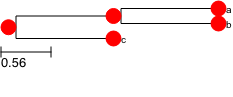

In [2]:
t = Tree( "((a,b),c);" )

# Basic tree style
ts = TreeStyle()
ts.show_leaf_name = True

# Creates an independent node style for each node, which is
# initialized with a red foreground color.
for n in t.traverse():
   nstyle = NodeStyle()
   nstyle["fgcolor"] = "red"
   nstyle["size"] = 15
   n.set_style(nstyle)

# Let's now modify the aspect of the root node
#t.img_style["size"] = 30
#t.img_style["fgcolor"] = "blue"

t.render("%%inline",tree_style=ts)

There is also a way to specify that each node have a "face," which can be an image or some other object.

This can also be a pie chart:


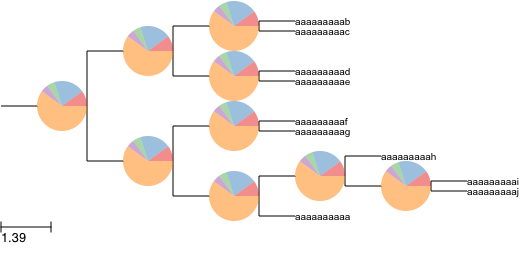

In [3]:
#Modified from: https://github.com/etetoolkit/ete/blob/master/ete3/test/test_treeview/barchart_and_piechart_faces.py

def get_example_tree():
    t = Tree()
    ts = TreeStyle()
    ts.layout_fn = layout
    ts.mode="r"
    ts.show_leaf_name = True
    t.populate(10)
    return t, ts

schema_names = COLOR_SCHEMES.keys()

def layout(node):
    if node.is_leaf():
        pass
    else:
        F= faces.PieChartFace([10,20,5,5,60],
                              colors=COLOR_SCHEMES["set1"],
                              width=50, height=50)
        F.border.width = None
        F.opacity = 0.5
        faces.add_face_to_node(F,node, 0, position="branch-right")

t,ts = get_example_tree()

for n in t.traverse():
    nstyle=NodeStyle()
    nstyle["size"] = 0
    n.set_style(nstyle)

t.render("%%inline",tree_style=ts)


The next step is to figure out how to make a *specific* pie chart appear on a *specific* node.

First, we have to name all of the nodes:

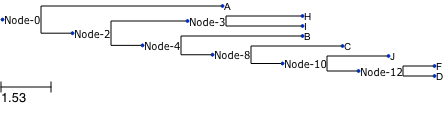

In [4]:
t = Tree( "((H,I), A, (B,(C,(J, (F, D)))));" )

#Root the tree 
t.set_outgroup("A")

#Name the nodes
edge_num = 0
for node in t.traverse():
    if not node.is_leaf():
        node.name = "Node-{}".format(edge_num)
    edge_num += 1

#Define a "Face Naming" function    
def node_name(node):
    if not node.is_leaf():
        F = TextFace(node.name)
        faces.add_face_to_node(F,node,0,"branch-top")
    
#Make the tips sorta line up...
t.convert_to_ultrametric()

#Use TreeStyle to associate the TextFace with our tree
ts = TreeStyle()
ts.layout_fn = node_name
ts.mode="r"
ts.show_leaf_name = True        


t.render("%%inline",tree_style=ts)




Now associate a set of pie chart percentages with each named node:

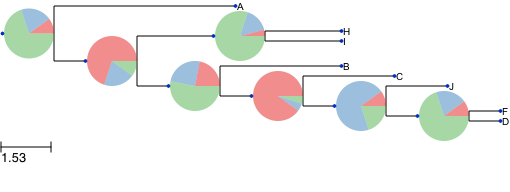

In [5]:
#Some pie chart data (must add up to 100)
node_pies = {"Node-0":[10,20,70],
             "Node-2":[70,20,10],
             "Node-3":[4,16,80],
             "Node-4":[22,25,53],
             "Node-8":[90,5,5],
             "Node-10":[10,70,20],
             "Node-12":[10,20,70],
             
            }

#Associate the PieChartFace only with internal nodes
def pie_nodes(node):
    if node.is_leaf():
        pass
    else: 
        F= faces.PieChartFace(node_pies[node.name],
                              colors=COLOR_SCHEMES["set1"],
                              width=50, height=50)
        F.border.width = None
        F.opacity = 0.5
        faces.add_face_to_node(F,node, 0, position="branch-right")

ts.layout_fn = pie_nodes
t.render("%%inline",tree_style=ts)

Phyparts returns a "node key" file that associates the names of nodes with the subtree that descends from that node. For example:
```
Node0    ((H,I), A, (B,(C,(J, (F, D)))))
Node1    (J, (F, D))
Node2    (C,(J,(F,D)))
```

The conflict and concordance is also associated with these same node names in the "hist" file:

```
Node0,66.83333333333331,61
Node1,44.83333333333334,1.0,1.0,47
Node2,24.333333333333332,1.0,1.0,32
```

In order to plot the concordance and conflict information, we will need to name the nodes on our tree very specifically. To do this, we have to figure out how to identify nodes by the subtending subtree. 

ETE3 has the method `get_topology_id()` which returns a unique MD5-esque value for a particular topology. If the topology of the PhyParts node tree and the ETE subtree is the same, these values should match.

In [6]:
subtree = Tree("(J, (F, D));")
subtree.render("%%inline")

for node in t.traverse():
    if node.get_topology_id() == subtree.get_topology_id():
        print node


   /-J
--|
  |   /-F
   \-|
      \-D


Putting it all together, using some examples modified from the PhyParts website.

{'Node1': [75.0, 12.5, 12.5], 'Node0': [40.0, 40.0, 20.0], 'Node2': [57.14285714285714, 28.57142857142857, 14.285714285714285]}


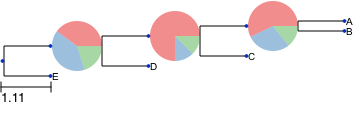

In [7]:
sptree = Tree("((((A,B),C),D),E);")
phyparts_node_key = ["Node0 (((A,B),C),D)","Node1 ((A,B),C)","Node2 (A,B)"]

#Node,concord,conflict1,conflict2,totConcord&Conflict

phyparts_hist = ["Node0,2.0,2.0,1.0,5.0", "Node1,6.0,1.0,1.0,8.0", "Node2,4.0,2.0,1.0,7.0"]

phyparts_pies = {}

for n in phyparts_hist:
    n = n.split(",")
    tot_genes = float(n.pop(-1))
    node_name = n.pop(0)
    phyparts_pies[node_name] = [float(x)/tot_genes*100 for x in n]

    
print phyparts_pies    
subtrees_dict = {n.split()[0]:Tree(n.split()[1]+";") for n in phyparts_node_key}

for node in sptree.traverse():
    for subtree in subtrees_dict:
        if node.get_topology_id() == subtrees_dict[subtree].get_topology_id():
            node.name = subtree
            
def phyparts_pie_layout(mynode):
    if mynode.name in phyparts_pies:
        F= faces.PieChartFace(phyparts_pies[mynode.name],
                              colors=COLOR_SCHEMES["set1"],
                              width=50, height=50)
        F.border.width = None
        F.opacity = 0.5
        faces.add_face_to_node(F,mynode, 0, position="branch-right")


ts = TreeStyle()
        
ts.layout_fn = phyparts_pie_layout
sptree.render("%%inline",tree_style=ts) 
    




For an example with real data, see the PhyParts_PieCharts notebook.